In [1]:
%load_ext autoreload
%autoreload 2

from tensorflow.keras.layers.experimental.preprocessing import StringLookup
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
from utils import *
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

In [2]:
words_path = "E:\\IAM_Words\\data"
words_list = []

words_file = open(f"{words_path}/words.txt", "r")
words = words_file.readlines()

for line in words:    
    # Append all lines not starting with #
    if line[0] != "#":
        if line.split(" ")[1] == "ok":
            words_list.append(line)
n = len(words_list)
words_list

['a01-000u-00-00 ok 154 408 768 27 51 AT A\n',
 'a01-000u-00-01 ok 154 507 766 213 48 NN MOVE\n',
 'a01-000u-00-02 ok 154 796 764 70 50 TO to\n',
 'a01-000u-00-03 ok 154 919 757 166 78 VB stop\n',
 'a01-000u-00-04 ok 154 1185 754 126 61 NPT Mr.\n',
 'a01-000u-00-05 ok 154 1438 746 382 73 NP Gaitskell\n',
 'a01-000u-00-06 ok 154 1896 757 173 72 IN from\n',
 'a01-000u-01-00 ok 156 395 932 441 100 VBG nominating\n',
 'a01-000u-01-01 ok 156 901 958 147 79 DTI any\n',
 'a01-000u-01-02 ok 156 1112 958 208 42 AP more\n',
 'a01-000u-01-03 ok 156 1400 937 294 59 NN Labour\n',
 'a01-000u-01-04 ok 156 1779 932 174 63 NN life\n',
 'a01-000u-01-05 ok 156 2008 933 237 70 NNS Peers\n',
 'a01-000u-02-00 ok 157 408 1106 65 70 BEZ is\n',
 'a01-000u-02-01 ok 157 541 1118 72 54 TO to\n',
 'a01-000u-02-02 ok 157 720 1114 113 63 BE be\n',
 'a01-000u-02-03 ok 157 916 1136 281 46 VBN made\n',
 'a01-000u-02-04 ok 157 1281 1117 80 59 IN at\n',
 'a01-000u-02-05 ok 157 1405 1140 64 35 AT a\n',
 'a01-000u-02-06 ok

In [3]:
# Do a 80:10:10 split of trainning, test and validation
split = int(0.8 * n)
train = words_list[:split]
test = words_list[split:]

val_split = int(0.5 * len(test))
validation = test[:val_split]
test = test[val_split:]

# Show samples count
print(
f"""Training samples: {len(train)}
Test samples: {len(test)}
Validation samples: {len(validation)}
"""
)

Training samples: 77164
Test samples: 9646
Validation samples: 9646



In [4]:
words_images = os.path.join(words_path, "words")

def get_img_paths_labels(samples):
    paths = []
    finalized_samples = []
    for (i, line) in enumerate(samples):
        
        # Remove unnecessary spaces at end if any
        line_clean = line.strip()
        line_split = line_clean.split(" ")
        
        img_name = line_split[0]
        portion1 = img_name.split("-")[0]
        portion2 = img_name.split("-")[1]
        img_path = os.path.join(words_images, portion1, portion1 + "-" + portion2, img_name + ".png")
        if os.path.getsize(img_path):
            paths.append(img_path)
            finalized_samples.append(line.split("\n")[0])

    return paths, finalized_samples


train_img_paths, train_labels = get_img_paths_labels(train)
validation_img_paths, validation_labels = get_img_paths_labels(validation)
test_img_paths, test_labels = get_img_paths_labels(test)


In [5]:
# Find max label length, vocabulary size and cleaning labels

def clean_labels(labels):
    cleaned_labels = []
    chars = set()
    max_label_len = 0
    for label in labels:
        label = label.split(" ")[-1].strip()
        for char in label:
            chars.add(char)
        max_label_len = max(max_label_len, len(label))
        cleaned_labels.append(label)
    return cleaned_labels, chars, max_label_len

train_clean, chars, max_label_len = clean_labels(train_labels)
validation_labels_cleaned, _, _ = clean_labels(validation_labels)
test_labels_cleaned, _, _ = clean_labels(test_labels)

print("Maximum length: ", max_label_len)
print("Vocab size: ", len(chars))

train_clean[:5]


Maximum length:  21
Vocab size:  78


['A', 'MOVE', 'to', 'stop', 'Mr.']

In [6]:
def clean_labels(labels):
    cleaned_labels = []
    for label in labels:
        label = label.split(" ")[-1].strip()
        cleaned_labels.append(label)
    return cleaned_labels


validation_labels_cleaned = clean_labels(validation_labels)
test_labels_cleaned = clean_labels(test_labels)


In [7]:
# Convert characters to integers
char_to_num = StringLookup(vocabulary=list(chars), mask_token=None)

# Convert integers to characters with inversion
num_to_char = StringLookup(vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True)

In [8]:
batch_size = 32
padding_token = 100
image_width = 96
image_height = 64
img_size=(image_width, image_height)
autotune = tf.data.AUTOTUNE

In [9]:
def process_labels(image_path, label):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, 1)
    image = distortion_free_resize(image, img_size)
    image = tf.cast(image, tf.float32) / 255.0

    # Vectorize label
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    length = tf.shape(label)[0]
    pad_amount = max_label_len - length
    label = tf.pad(label, paddings=[[0, pad_amount]], constant_values=padding_token)
    return {"image": image, "label": label}

In [10]:
def prepare_data(image_paths, labels):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels)).map(
        process_labels, num_parallel_calls=autotune
    )
    return dataset.batch(batch_size).cache().prefetch(autotune)

In [11]:
train_ds = prepare_data(train_img_paths, train_clean)
validation_ds = prepare_data(validation_img_paths, validation_labels_cleaned)
test_ds = prepare_data(test_img_paths, test_labels_cleaned)

In [16]:
class CTCLayer(keras.layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        return y_pred


def build_model():
    # Inputs to the model
    input_img = keras.Input(shape=(image_width, image_height, 1), name="image")
    labels = keras.layers.Input(shape=(None,), name="label")

    x = keras.layers.Conv2D(
        32, (3, 3), activation="relu",
        kernel_initializer="glorot_normal",
        padding="same",
    )(input_img)
    x = keras.layers.MaxPooling2D((2, 2))(x)

    # Reshape before passing to RNN
    new_shape = ((image_width // 4), (image_height // 4) * 128)
    x = keras.layers.Reshape(target_shape=new_shape)(x)
    x = keras.layers.Dense(128, activation="relu")(x)
    x = keras.layers.Dropout(0.2)(x)

    # RNN.
    x = keras.layers.Bidirectional(
        keras.layers.LSTM(128, return_sequences=True, dropout=0.2), merge_mode="concat"
    )(x)

    # Adding +2 to output labels due to tokens introduced by CTC
    x = keras.layers.Dense(len(char_to_num.get_vocabulary()) + 2, activation="softmax", name="denseFC")(x)
    output = CTCLayer(name="ctc_loss")(labels, x)

    
    model = keras.models.Model(
        inputs=[input_img, labels], 
        outputs=output, 
        name="RNN-BDLSTM"
    )
    
    model.compile(optimizer="rmsprop")
    return model


# Get the model.
model = build_model()
model.summary()

Model: "RNN-BDLSTM"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 96, 64, 1)]  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 96, 64, 32)   320         image[0][0]                      
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 48, 32, 32)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
reshape_2 (Reshape)             (None, 24, 2048)     0           max_pooling2d_2[0][0]            
_________________________________________________________________________________________

In [17]:
validation_images = []
validation_labels = []

for batch in validation_ds:
    validation_images.append(batch["image"])
    validation_labels.append(batch["label"])

In [23]:
def edit_distance(labels, predictions):
    sparse_labels = tf.cast(tf.sparse.from_dense(labels), dtype=tf.int64)
    input_len = np.ones(predictions.shape[0]) * predictions.shape[1]
    predictions_decoded = keras.backend.ctc_decode(
        predictions, 
        input_length=input_len, 
        greedy=True
    )[0][0][:, :max_label_len]
    sparse_predictions = tf.cast(
        tf.sparse.from_dense(predictions_decoded), dtype=tf.int64
    )

    edit_distances = tf.edit_distance(sparse_predictions, sparse_labels, normalize=False)
    return tf.reduce_mean(edit_distances)


class EditDistanceCallback(keras.callbacks.Callback):
    def __init__(self, pred_model):
        super().__init__()
        self.prediction_model = pred_model

    def on_epoch_end(self, epoch, logs=None):
        edit_distances = []

        for i in range(len(validation_images)):
            labels = validation_labels[i]
            predictions = self.prediction_model.predict(validation_images[i])
            edit_distances.append(edit_distance(labels, predictions).numpy())

        print(
            f"Mean edit distance for epoch {epoch + 1}: {np.mean(edit_distances):.3f}"
        )

In [24]:
epochs = 8

model = build_model()
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="denseFC").output
)

history = model.fit(
    train_ds,
    validation_data=validation_ds,
    epochs=epochs,
    callbacks=[EditDistanceCallback(prediction_model)],
)

Epoch 1/8
2412/2412 [==============================] - 201s 82ms/step - loss: 14.0857 - val_loss: 9.7593
Mean edit distance for epoch 1: 20.242
Epoch 2/8
2412/2412 [==============================] - 166s 69ms/step - loss: 10.2797 - val_loss: 8.4594
Mean edit distance for epoch 2: 19.923
Epoch 3/8
2412/2412 [==============================] - 169s 70ms/step - loss: 8.8579 - val_loss: 7.7960
Mean edit distance for epoch 3: 19.556
Epoch 4/8
2412/2412 [==============================] - 167s 69ms/step - loss: 7.8165 - val_loss: 6.7368
Mean edit distance for epoch 4: 19.258
Epoch 5/8
2412/2412 [==============================] - 168s 70ms/step - loss: 6.9902 - val_loss: 6.1741
Mean edit distance for epoch 5: 19.055
Epoch 6/8
2412/2412 [==============================] - 167s 69ms/step - loss: 6.3487 - val_loss: 5.6387
Mean edit distance for epoch 6: 18.918
Epoch 7/8
2412/2412 [==============================] - 168s 69ms/step - loss: 5.9093 - val_loss: 5.6332
Mean edit distance for epoch 7: 18.8

In [25]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search.
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_label_len
    ]
    # Iterate over the results and get back the text.
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.math.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

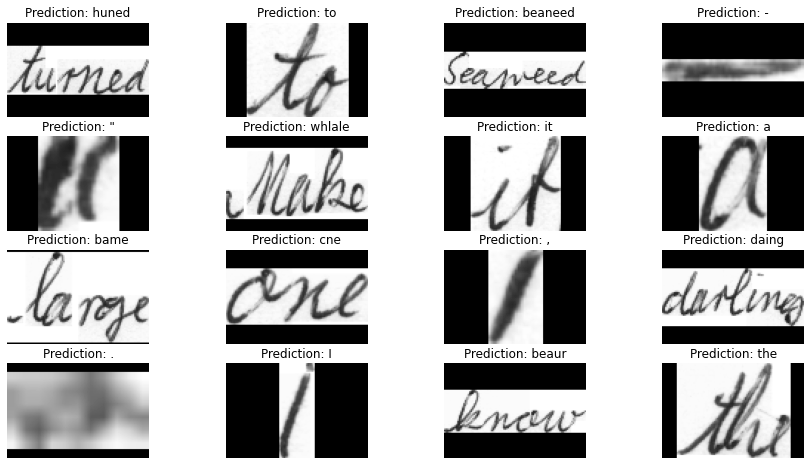

In [26]:
# Test predictions

for batch in test_ds.take(1):
    batch_images = batch["image"]
    _, ax = plt.subplots(4, 4, figsize=(15, 8))

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    for i in range(16):
        img = batch_images[i]
        img = tf.image.flip_left_right(img)
        img = tf.transpose(img, perm=[1, 0, 2])
        img = (img * 255.0).numpy().clip(0, 255).astype(np.uint8)
        img = img[:, :, 0]

        title = f"Prediction: {pred_texts[i]}"
        ax[i // 4, i % 4].imshow(img, cmap="gray")
        ax[i // 4, i % 4].set_title(title)
        ax[i // 4, i % 4].axis("off")

plt.show()

In [43]:
def model_diagnosis(history, epochs):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, epochs + 1)
    fig = plt.figure()
    fig.tight_layout(pad=5.0)
    
    plt.plot(epochs, loss, 'g+', label = 'Trainning loss')
    plt.plot(epochs, val_loss, 'g-', label = 'Validation loss')
    plt.title('Trainning and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

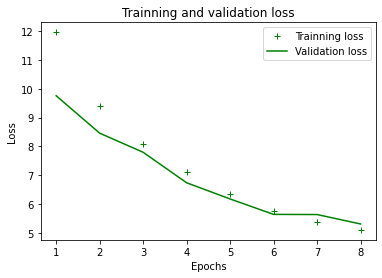

In [44]:
model_diagnosis(history, epochs)